In [1]:
%load_ext tensorboard

In [2]:
#!/usr/bin/python3
import argparse
import os
import re
import cv2
import random
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import tensorflow as tf
import tensorboard
from keras.utils.vis_utils import plot_model

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
def LoadData(imgPath:str=None, maskPath:str=None, shape:int=256, train_ratio:float=0.90, evaluate:bool=False):
    images = []
    masks  = []

    training_file_path="data/split_list.csv"

    if not os.path.exists(training_file_path):
        imgNames = os.listdir(imgPath)
        random.shuffle(imgNames)
        df = pd.DataFrame(imgNames)
        df.to_csv(training_file_path)

    df = pd.read_csv(training_file_path).iloc[:,-1]
    imgNames = list(df.to_dict().values())

    compression_dict = {
        'bag':'accessories',
        'belt':'accessories',
        'boots':'shoes',
        'bracelet':'accessories',
        'clogs':'shoes',
        'earrings':'accessories',
        'flats':'shoes',
        'glasses':'accessories',
        'gloves':'accessories',
        'heels':'shoes',
        'loafers':'shoes',
        'necklace':'accessories',
        'pumps':'shoes',
        'purse':'accessories',
        'ring':'accessories',
        'sandals':'shoes',
        'sneakers':'shoes',
        'stockings':'socks',
        'sunglasses':'accessories',
        'tie':'accessories',
        'tights':'socks',
        'wallet':'accessories',
        'watch':'accessories',
        'wedges':'shoes',
        'sweatshirt':'hoodie',
    }
    
    pixel_values = []
    class_dict = {}
    with open('data/class_dict.csv','r') as cdf:
        next(cdf)
        for idx, line in enumerate(cdf):
            spl = line.replace(" ","").replace("\n","").split(",")
            name = spl[0]
            pixel_values.append([[int(x) for x in spl[1:]]])
            class_dict[name] = [idx,idx]
    
    for k,v in compression_dict.items():
        orig_idx = class_dict[k][0]
        new_idx  = class_dict[v][1]
        class_dict[k] = [orig_idx,new_idx]
        
    for orig_idx, new_idx in class_dict.values():
        if orig_idx != new_idx:
            pixel_values[new_idx].append(pixel_values[orig_idx][0])
            pixel_values[orig_idx] = []
        
    
    pixel_values = [x for x in pixel_values if x]
    
    num_dims = len(pixel_values)

    maskNames = []

    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.jpg', '.png', mem))

    imgAddr  = imgPath + '/'
    maskAddr = maskPath + '/'

    len_training = int(len(imgNames)*train_ratio)
    len_test = len(imgNames) - len_training

    if not evaluate:
        images_file  = "data/train_images.npy"
        masks_file   = "data/train_masks.npy"
    else:
        images_file  = "data/test_images.npy"
        masks_file   = "data/test_masks.npy"

    if not (os.path.exists(images_file) and os.path.exists(masks_file)):
        for i in range(len_training):
            try:
                if not evaluate:
                    img = plt.imread(imgAddr + imgNames[i])
                    mask = plt.imread(maskAddr + maskNames[i])
                else:
                    img = plt.imread(imgAddr + imgNames[i+len_training])
                    mask = plt.imread(maskAddr + maskNames[i+len_training])
            except:
                continue

            img = cv2.resize(img, (shape, shape))
            mask = (cv2.resize(mask, (shape, shape)) * 256).astype(np.uint8)

            output_mask = np.zeros((256,256,num_dims),dtype=np.float32)
        
            for dim, px in enumerate(pixel_values):
                for individual_px in px:
                    indices = np.all(mask==individual_px, axis=-1)
                    output_mask[indices,dim] = 1.0

            images.append(img)
            masks.append(output_mask)

        images = np.array(images)
        masks  = np.array(masks)

        print("Caching data...")
        np.save(images_file,images)
        np.save(masks_file, masks)
    else:
        print("Loading cached data...")
        images = np.load(images_file)
        masks  = np.load(masks_file)

    print(f"Images taking up {(images.size * images.itemsize)/1e6}MB")
    print(f"Masks taking up {(masks.size  * masks.itemsize)/1e6}MB")
        
#     return tf.data.Dataset.from_tensor_slices(images), tf.data.Dataset.from_tensor_slices(masks)
#     return tf.data.Dataset.from_tensor_slices((images, masks))
    return images, masks

In [5]:
def GetModel(lr:float,visualize:bool=False) -> tf.keras.models.Sequential:

    # defining our CNN for encoding and decoding
    model = tf.keras.models.Sequential([
        #encoder
        tf.keras.layers.Input(shape= (256, 256, 3)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu', padding='valid'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),

        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), activation='relu', padding='same'),

        tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
        
        #decoder
        tf.keras.layers.UpSampling2D(size=(2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D(size=(2,2)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D(size=(2,2)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters=34, kernel_size=(3,3), padding='same'),
        tf.keras.layers.Reshape((256*256,34)),
        tf.keras.layers.Activation('softmax'),
        tf.keras.layers.Reshape((256,256,34)),
    ])
    if visualize:
#         model.summary()
        plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr), loss='categorical_crossentropy', metrics=['acc'])
    #model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr), loss='mean_squared_error', metrics=['acc'])

    return model

In [6]:
def run_model(evaluate:bool=False, load:bool=False, epoch:int=10, lr:float=5e-5, visualize:bool=False):
#     parser = argparse.ArgumentParser()
#     parser.add_argument("--evaluate",action='store_true')
#     parser.add_argument("--load", action='store_true')
#     parser.add_argument("--epoch", type=int, default=10)
#     parser.add_argument("--lr", type=float, default=5e-5)

#     args = parser.parse_args()

    if evaluate:
        print("Running in evaluation mode...")
    else:
        print("Running in training mode...")
        print(f"Hyperparameters: {epoch} epochs, {lr} learning rate")

    print("Loading data...")
    images, masks = LoadData(imgPath='data/images', maskPath='data/labels/pixel_level_labels_colored', shape=256, evaluate=evaluate)

    #plt.subplot(1,2,1)
    #plt.imshow(train['img'][1])
    #plt.subplot(1,2,2)
    #plt.imshow(train['mask'][1])
    #plt.show()

    print("Compiling model...")
    model = GetModel(lr,visualize=visualize)

    if load or evaluate:
        print("Loading parameters for model...")
        model.load_weights('weights/image_segmentation.weights')

    if True:
        if evaluate:
            print("Evaluating model...")
            predicted_masks = model.predict(images)
            results = model.evaluate(images,masks)
            print(f"Results: {results}")

            print(f"output size: {np.shape(predicted_masks[0])}, desired size: {np.shape(masks[0])}")
            print(f"output dtype: {predicted_masks[0].dtype}, desired dtype: {masks[0].dtype}")

#             for i in range(34):
#                 plt.subplot(1,3,1)
#                 plt.imshow(images[0])
#                 plt.subplot(1,3,2)
#                 plt.imshow(masks[0][:,:,i])
#                 plt.subplot(1,3,3)
#                 plt.imshow(predicted_masks[0][:,:,i])
#                 plt.show()
            for i in range(5):
                plt.subplot(1,3,1)
                plt.imshow(images[i])
                plt.subplot(1,3,2)
                plt.imshow(np.argmax(masks[i],axis=-1))
                plt.subplot(1,3,3)
                plt.imshow(np.argmax(predicted_masks[i],axis=-1))
                plt.show()

        else:
            print("Beginning training...")
            loss_cb = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=25)
            
            logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
            tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logdir)
            
            checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(save_freq='epoch',save_weights_only=True,filepath='weights/model_checkpoint')

            retVal = model.fit(images, masks, epochs=epoch, verbose=1, callbacks=[tensorboard_cb,loss_cb,checkpoint_cb])

            plt.plot(retVal.history['loss'], label = 'training_loss')
            plt.plot(retVal.history['acc'], label = 'training_accuracy')
            plt.legend()
            plt.grid(True)
            plt.show()

            model.save_weights('weights/image_segmentation.weights')

In [13]:
run_model(epoch=50,lr=0.005,visualize=True,load=True)

Running in training mode...
Hyperparameters: 50 epochs, 0.005 learning rate
Loading data...
Loading cached data...
Images taking up 59.768832MB
Masks taking up 2709.520384MB
Compiling model...
Loading parameters for model...
Beginning training...


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Running in evaluation mode...
Loading data...
Loading cached data...
Images taking up 19.857408MB
Masks taking up 900.202496MB
Compiling model...
Loading parameters for model...
Evaluating model...
4/4 [==============================] - 0s 37ms/step - loss: 0.7148 - acc: 0.8088
Results: [0.7148435711860657, 0.8087751865386963]
output size: (256, 256, 34), desired size: (256, 256, 34)
output dtype: float32, desired dtype: float32


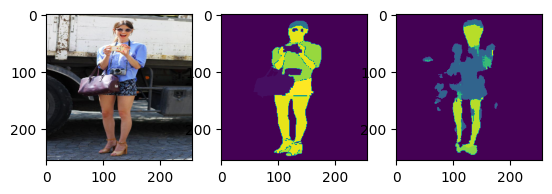

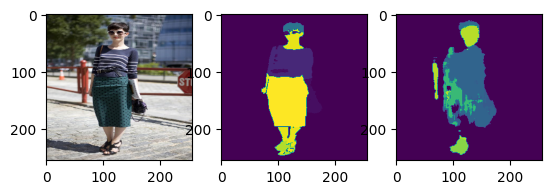

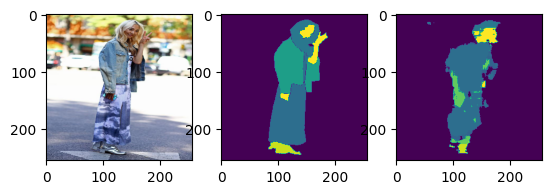

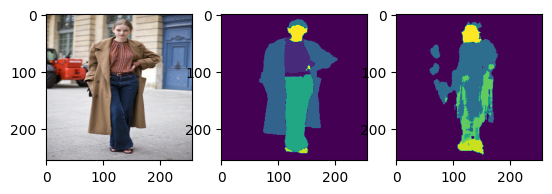

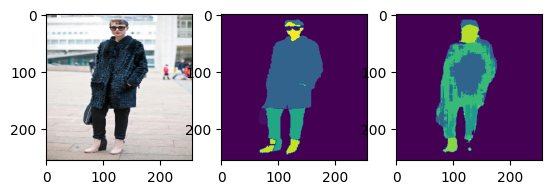

In [12]:
run_model(evaluate=True)